## FlowDMS Assay Report

1. [Barcode Sequencing Distributions](#part1)
2. [Variant Effect Profiles and Midpoints](#part2)
3. [Visualizations](#part3)

In [41]:
library(magrittr)
library(data.table)
library(ggrepel)
library(ggpubr)
library(vroom)
library(scales)
library(scico)
library(ggridges)
library(knitr)
library(ggbeeswarm)
library(fs)
library(patchwork)
library(ggnewscale)
library(furrr)
library(tidyverse)

source("src/dms-analysis-utils.R")

### Barcode Sequencing Distributions <a name="part1"></a>

In [4]:
mapped_counts <- vroom("pipeline/OCNT-VAMPLIB-1-assay-run2.mapped-counts-split.tsv",
                       col_names = c("sample", "barcode",  "count", "lib", "chunk", 
                                        "wt_aa", "pos", "mut_aa", "wt_codon", "mut_codon", "chunkGrp",
                                        "dox", "condition", "condition_conc","clone"))  %>%
    mutate(mut_aa = if_else(mut_aa %in% c("*", "X"), "*", mut_aa),
           condition = as.factor(paste0(condition, condition_conc)),
           mut_aa = if_else(wt_aa == mut_aa | is.na(mut_aa), "WT", mut_aa),
           mut_aa = relevel(as.factor(mut_aa), ref = "WT"))

bc_counts_aa <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_aa,mut_aa,pos) %>%
    count()

bc_counts_codon <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_codon,mut_codon,pos) %>%
    count()

res_count <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts")

codon_count <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts")

res_count_log <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts, log10")

codon_count_log <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts, log10")

Rows: 5169295 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): sample, barcode, lib, chunk, wt_aa, mut_aa, wt_codon, mut_codon, co...
dbl (3): count, pos, condition_conc
lgl (3): chunkGrp, dox, clone

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


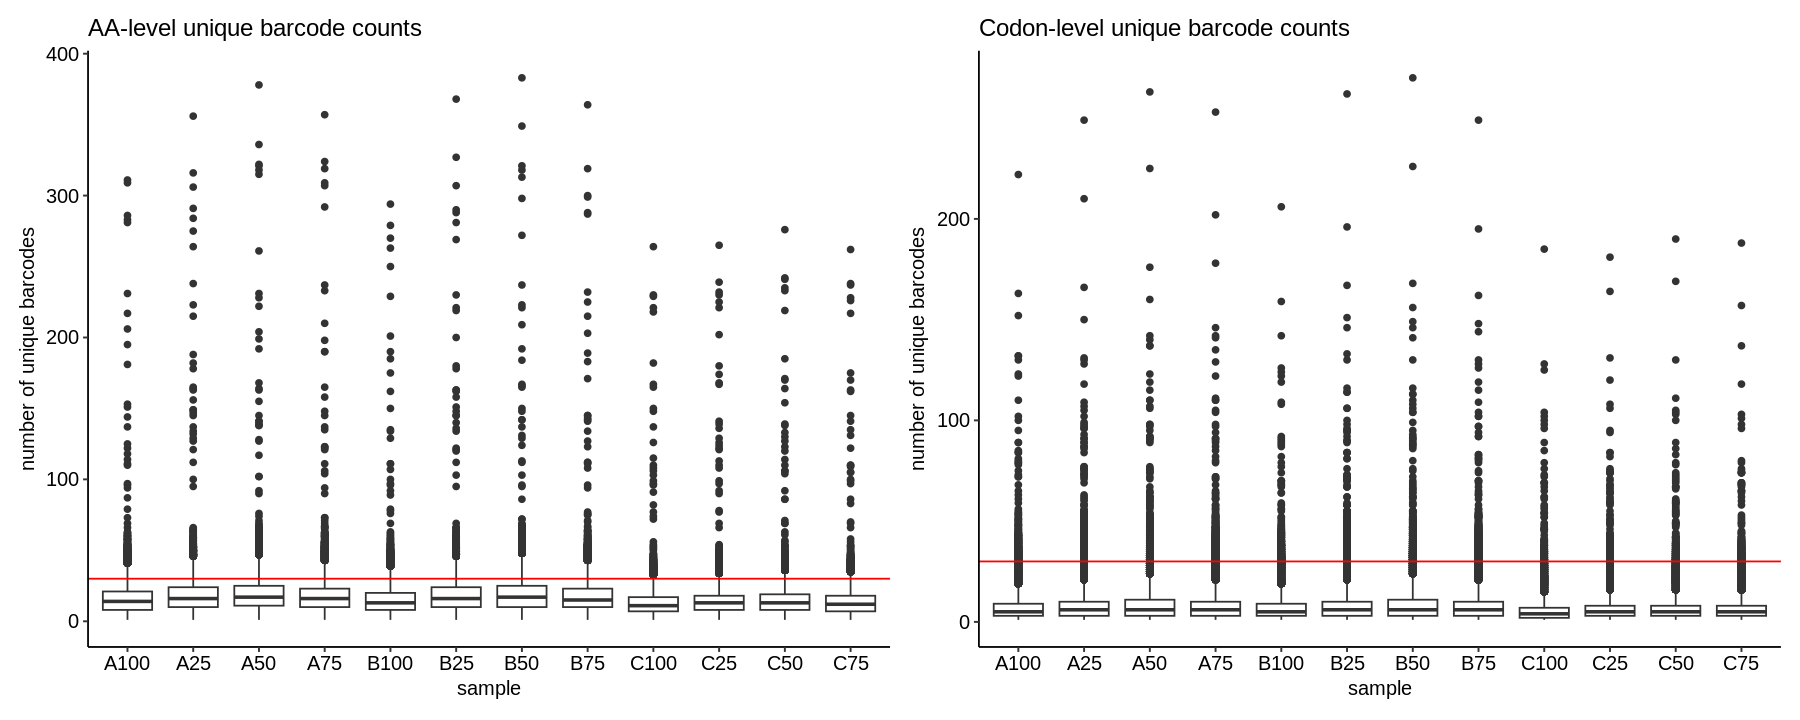

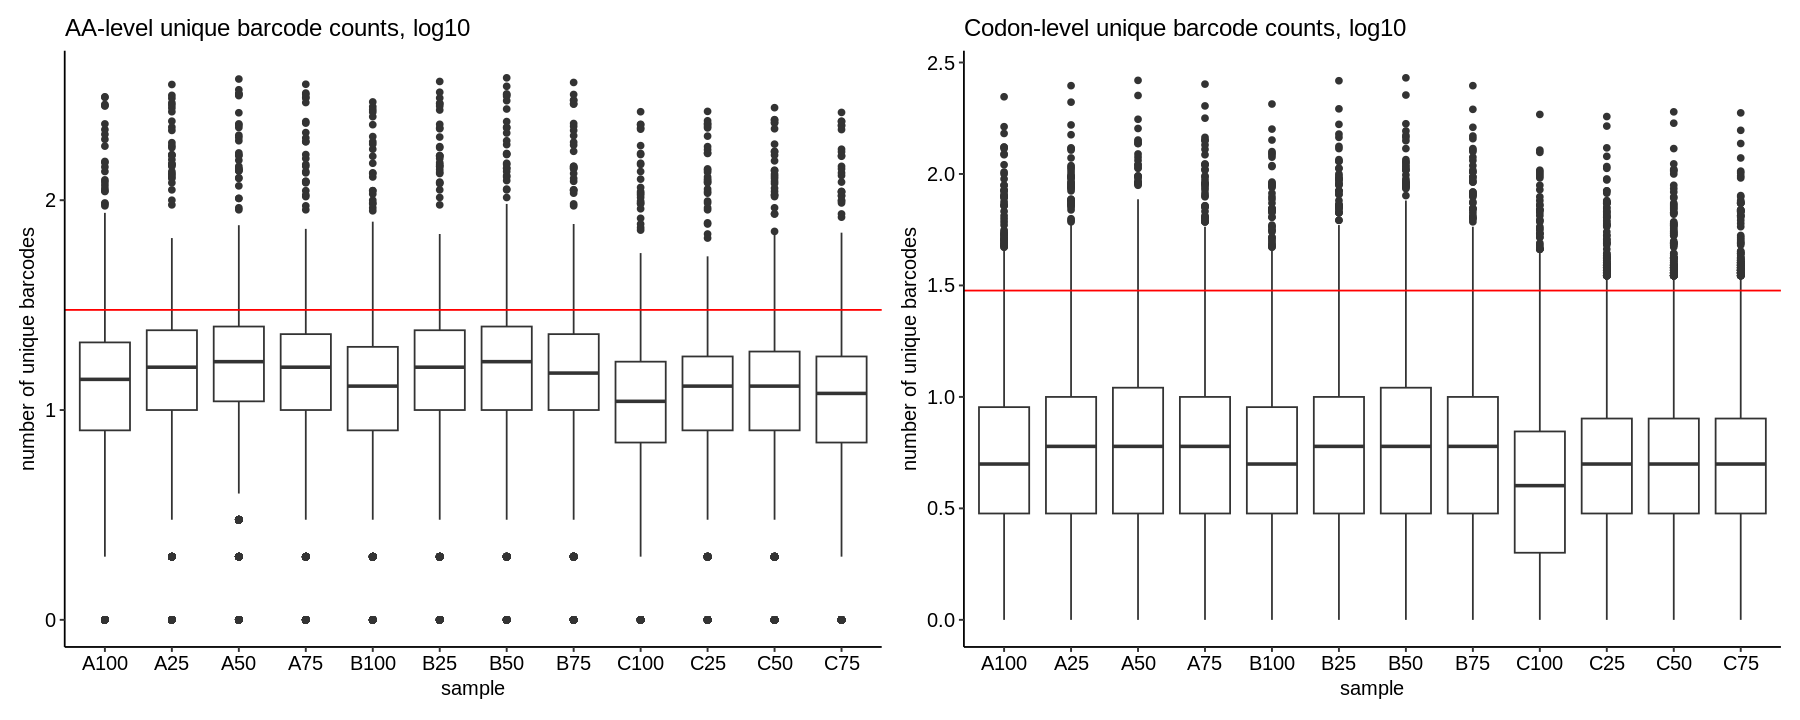

In [5]:
options(repr.plot.width = 15, repr.plot.height = 6)
res_count + codon_count
res_count_log + codon_count_log 

To get a sense of positional distribution, we can show the same data as lineplots across the length of TYK2. Below is an example using the first sample; the remaining plots can be found [here](./coverage-plots):

In [11]:
wt_tyk2 <- read_tsv("data/tyk2/tyk2-wt-aa.tsv")
coverage_plots <- map(.x = unique(bc_counts_aa$sample),
                      .f = ~plot_coverage(bcs = bc_counts_aa,
                                          wt_aa = wt_tyk2,
                                          sample_id = .,
                                          destdir = "OCNT-VAMPLIB-1-assay-run2"))

Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(pos, mut_aa)`
Joining with `by = join_by(pos, mut_aa)`
Joining with `by = join_by(pos, mut_aa)`
Joining with `by = join_by(pos, mut_aa)`
Joining with `by = join_by(pos, mut_aa)`
Joining with `by = join_by(pos, mut_aa)`
Joining with `by = join_by(pos, mut_aa)`
Joining with `by = join_by(pos, mut_aa)`
Joining with `by = join_by(pos, mut_aa)`
Joining with `by = join_by(pos, mut_aa)`
Joining with `by = join_by(pos, mut_aa)`
Joining with `by = join_by(pos, mut_aa)`


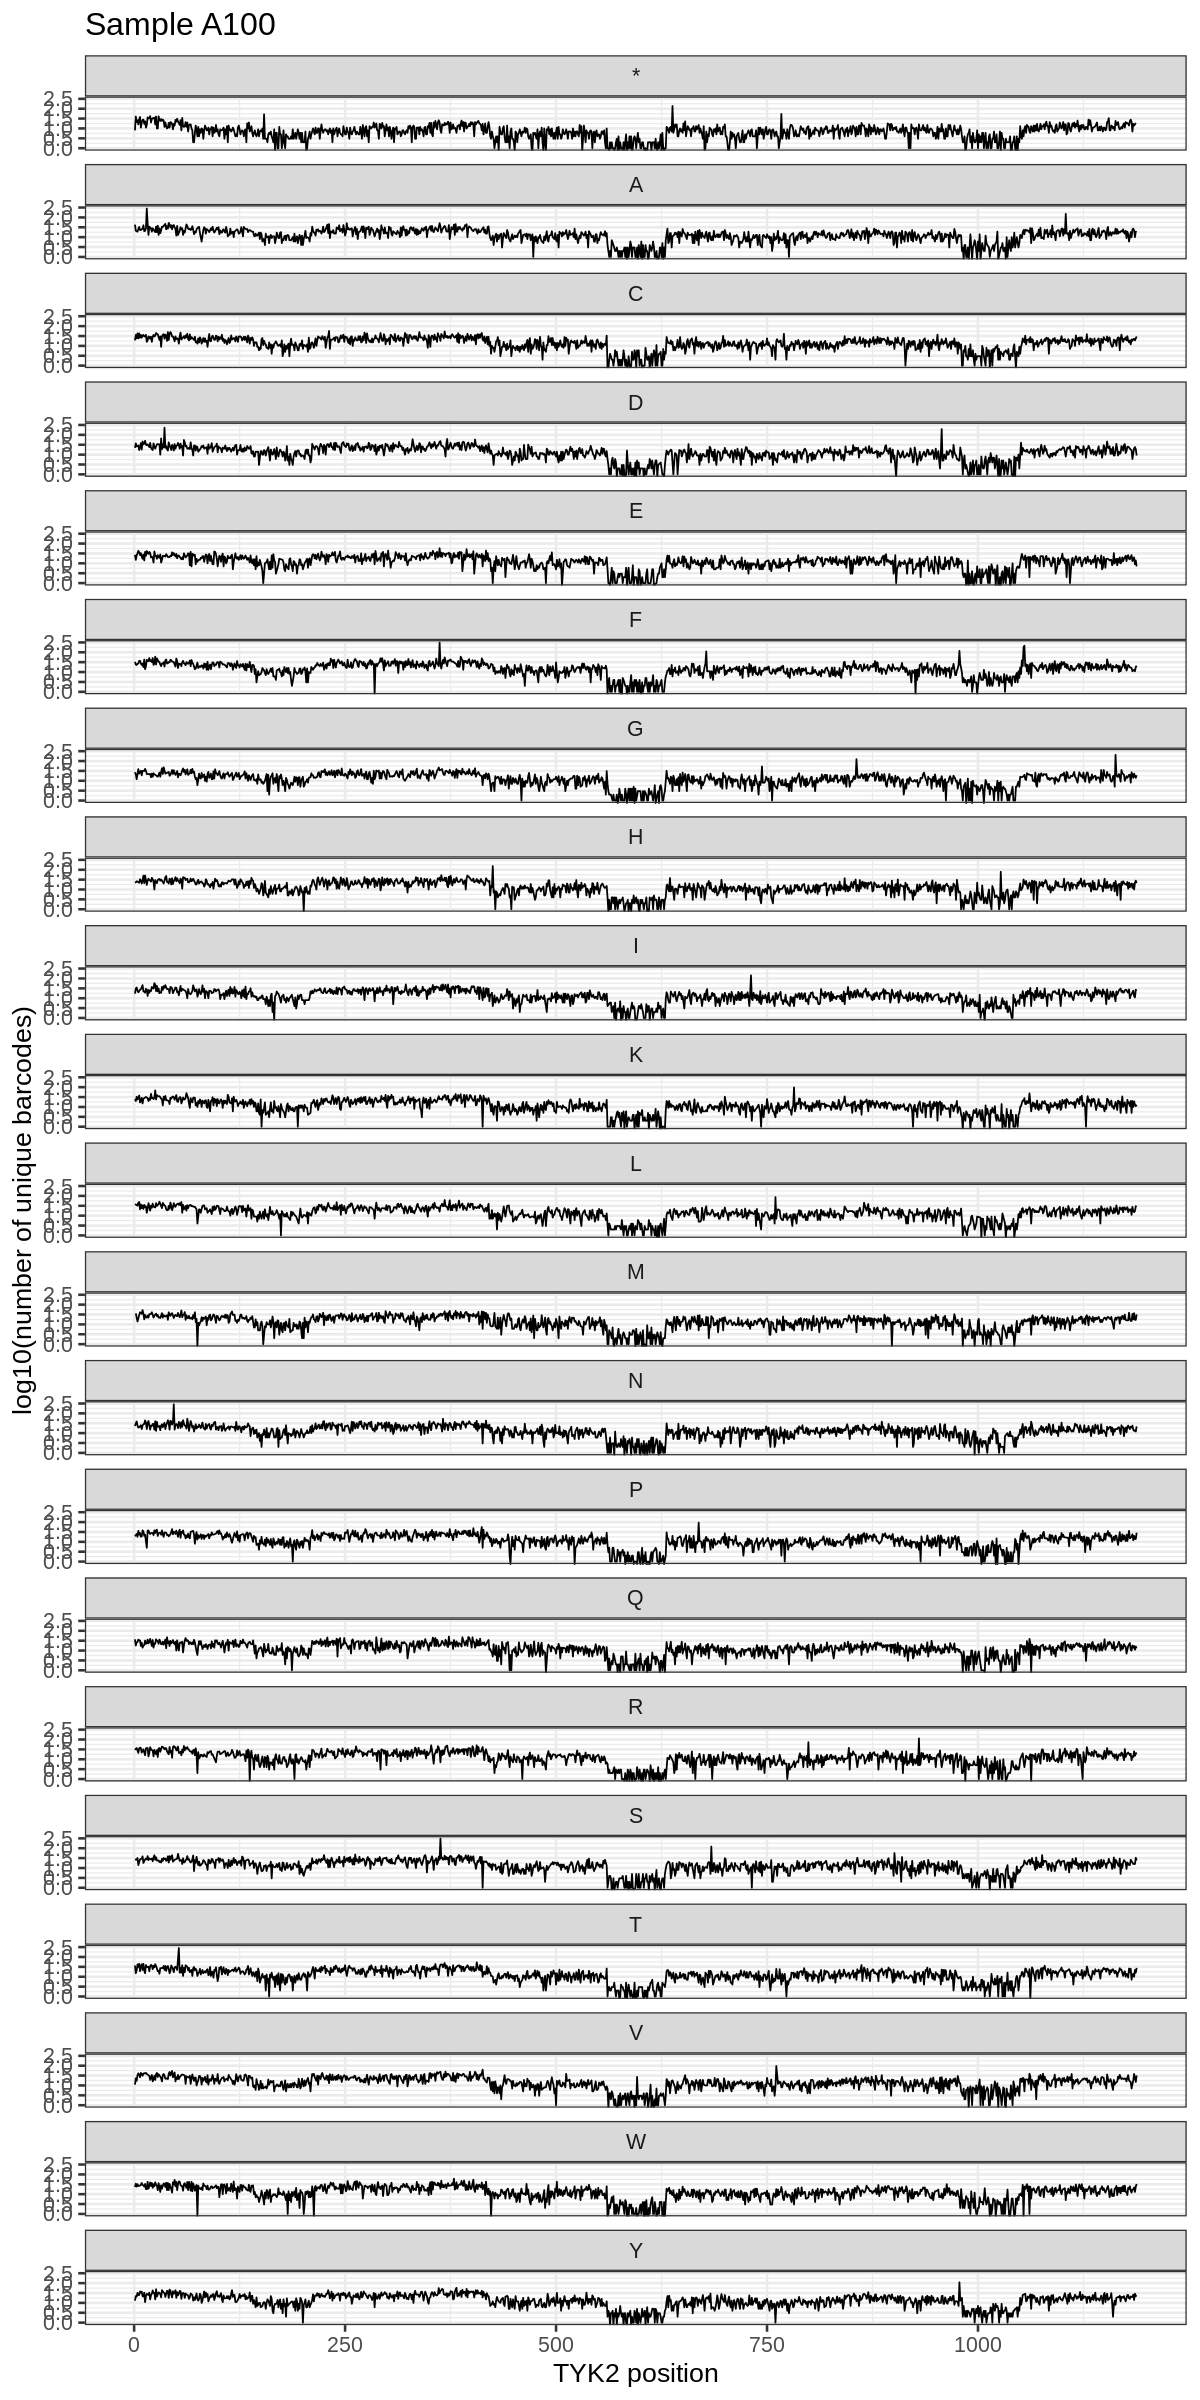

In [12]:
options(repr.plot.width = 10, repr.plot.height = 20)
coverage_plots[[1]]

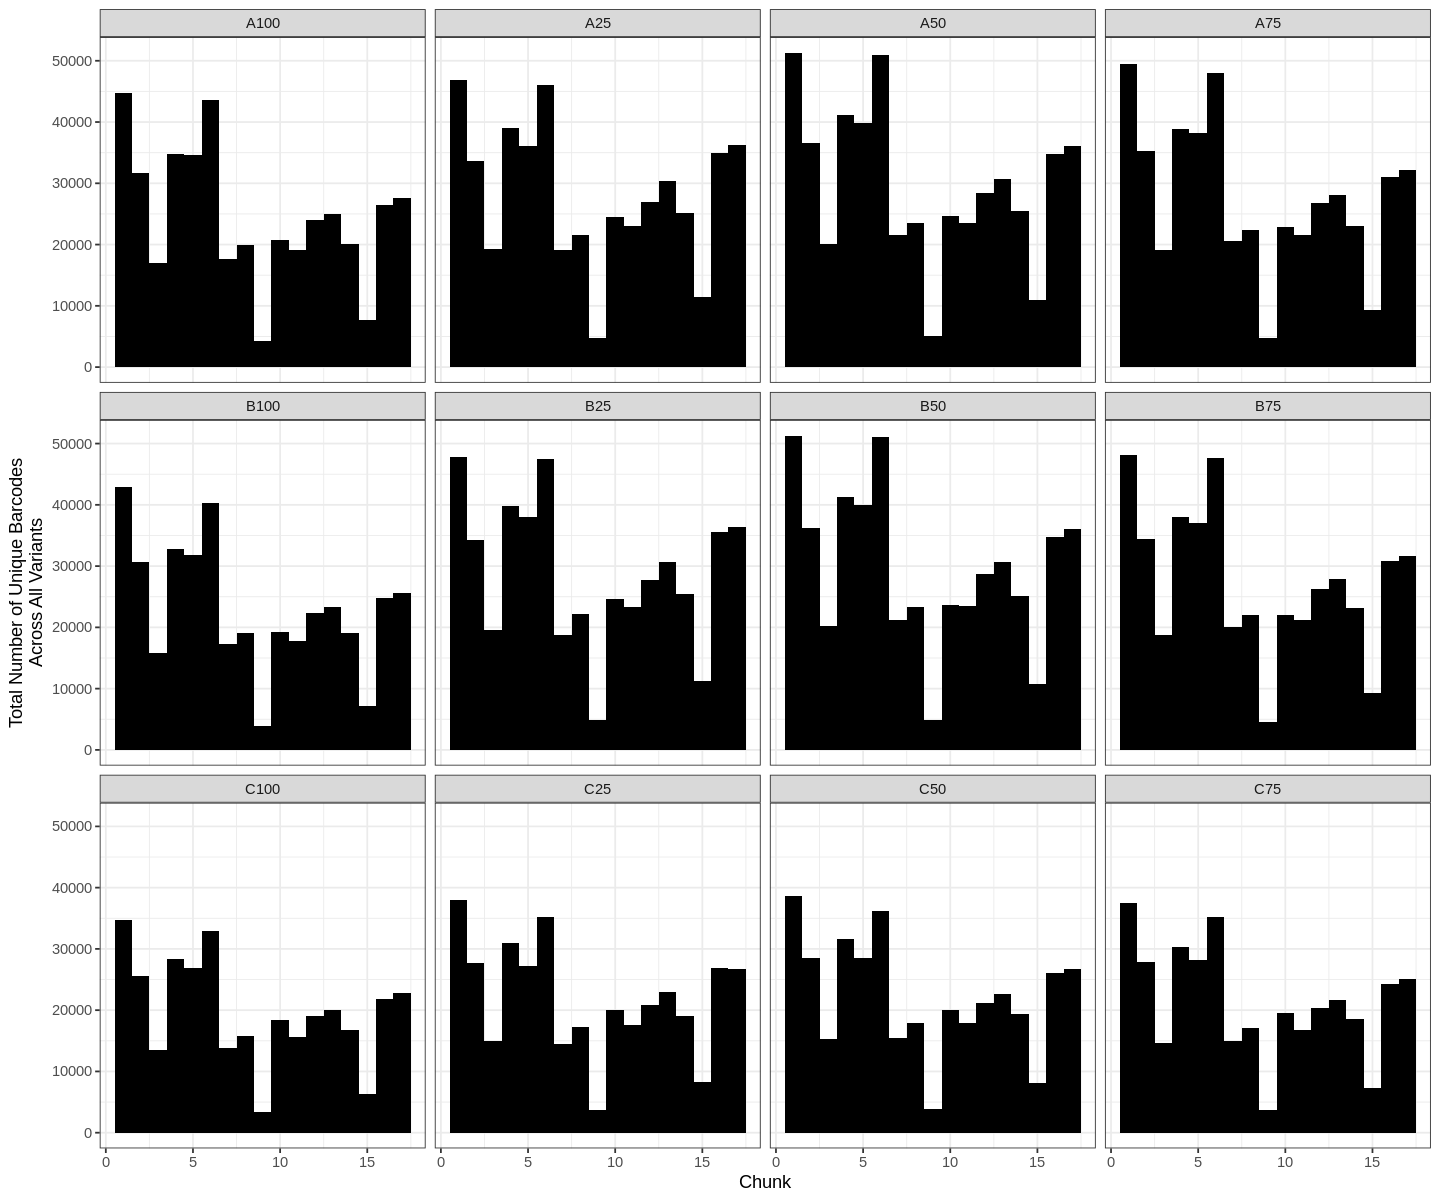

In [15]:
options(repr.plot.width = 12, repr.plot.height = 10)
mapped_counts %>%
    ungroup() %>%
    count(sample, chunk) %>%
    mutate(chunk = gsub("rc", "", chunk),
           chunk = as.numeric(chunk)) %>%
    ggplot() +
        geom_bar(aes(x = chunk, y = n), width = 1, color = NA, fill = "black", stat = "identity") +
        theme_bw() +
        facet_wrap(~sample, ncol = 4) +
        xlab("Chunk") + ylab("Total Number of Unique Barcodes\nAcross All Variants")

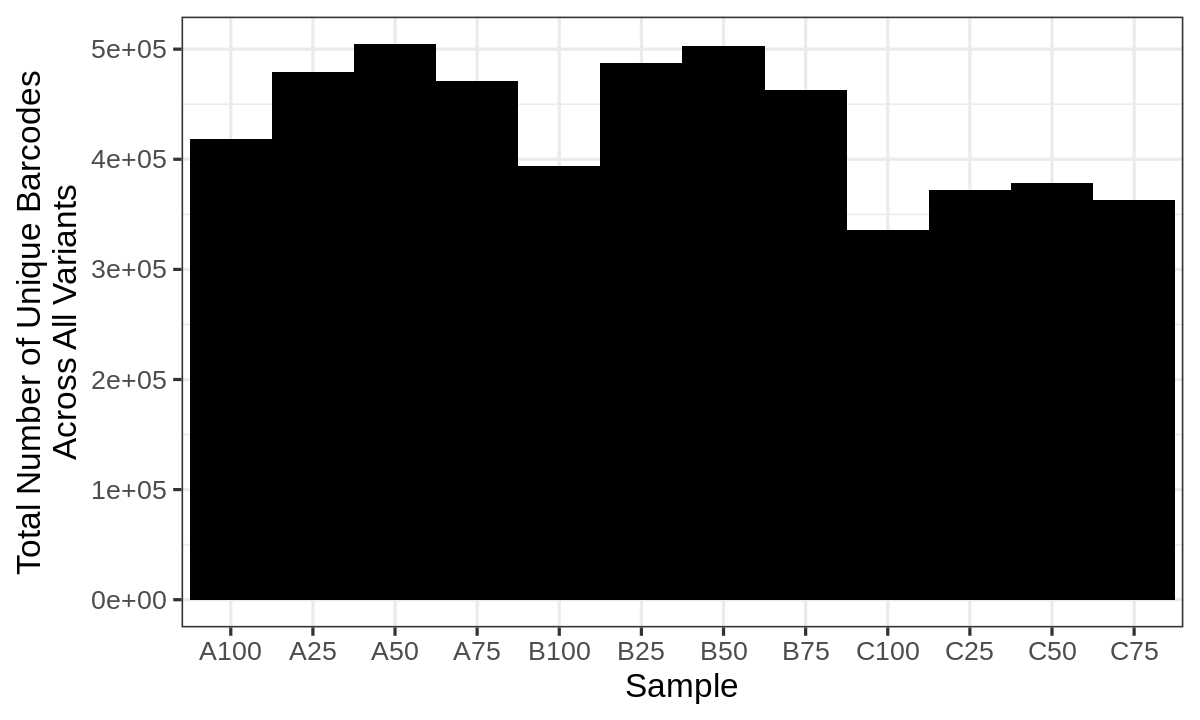

In [14]:
options(repr.plot.width = 10, repr.plot.height = 6)
mapped_counts %>%
    ungroup() %>%
    count(sample) %>%
    ggplot() +
        geom_bar(aes(x = sample, y = n), width = 1, color = NA, fill = "black", stat = "identity") +
        theme_bw(base_size = 20) +
        xlab("Sample") + ylab("Total Number of Unique Barcodes\nAcross All Variants")

### Variant Effect Profiles and Midpoints <a name="part2"></a>

In [3]:
raw_sumstats <- read_tsv("sumstats/TYK2-VAMP/run2/OCNT-VAMPLIB-1-assay-run2-vampseq.sumstats.tsv")
sumstats <-  raw_sumstats %>%
    filter(grepl("aa",term), pos != 1188) %>%
    separate(term, c("condition", "aa"), ":") %>%
    mutate(estimate = estimate / log(2),
           std.error = std.error / log(2),
           condition = gsub("condition_conc", "", condition),
           group = if_else(aa %in% c("mut_aa*", "mut_aaX"), chunk, "Non-Stop"),
           aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*","X"), "*", aa))

marginals <- raw_sumstats %>% filter(is.na(term))
weights <- marginals %>%
    dplyr::select(condition_conc, chunk, pos, mut_aa, estimate, std.error) %>%
    rename("bin" = "condition_conc") %>%
    group_by(chunk, pos, mut_aa) %>%
    mutate(bin = case_when(bin == 25 ~ 0.125,
                           bin == 50 ~ 0.375,
                           bin == 75 ~ 0.625,
                           TRUE ~ 0.875))

aa_uniq <- unique(sumstats$aa)
pos_uniq <- 1:1187

weights_nest <- weights %>% nest(data = c(-chunk, -pos, -mut_aa))
metadata_df <- weights_nest %>% dplyr::select(-data)

Rows: 199228 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (7): chunk, effect, component, group, term, mut_aa, version
dbl (8): pos, estimate, std.error, statistic, p.value, dispersion, condition...
lgl (1): clone

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [42]:
# this cell takes a few minutes to run
plan(multicore, workers = 40)
midpoints <- future_map2_dfr(.x = weights_nest$data,
                             .y = transpose(metadata_df),
                             ~generate_resamples(.x$estimate,
                                                 .x$std.error,
                                                 .y,
                                                 num = 1000))

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if
`.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if
`.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statis

In [44]:
wt_scores <- midpoints %>%
    filter(mut_aa == "WT") %>% 
    group_by(chunk) %>%
    summarize("WT score" = median(score_mean),
              "WT score standard error" = median(score_se))

wt_scores %>% kable("markdown")



|chunk |  WT score| WT score standard error|
|:-----|---------:|-----------------------:|
|1     | 0.6447912|               0.0961789|
|10    | 0.7349122|               0.0101506|
|11    | 0.7279167|               0.0155198|
|12rc  | 0.7385077|               0.0298568|
|13    | 0.7241531|               0.0357402|
|14    | 0.7381060|               0.0163644|
|15    | 0.7146434|               0.0198638|
|16    | 0.7047822|               0.0103863|
|17    | 0.7075321|               0.0131014|
|2     | 0.6149431|               0.0563844|
|3     | 0.7457294|               0.0265146|
|4     | 0.7262153|               0.0206718|
|5     | 0.6944908|               0.0303435|
|6     | 0.7118432|               0.0399839|
|7     | 0.7159258|               0.0590188|
|8     | 0.7107589|               0.0623667|
|9     | 0.7207521|               0.0363604|

In [77]:
midpoints_test <- midpoints %>%
    filter(mut_aa != "WT") %>%
    left_join(wt_scores, by = "chunk") %>%
    mutate(estimate = score_mean - `WT score`,
           std.error = sqrt(score_se^2 + `WT score standard error`^2),
           statistic = estimate/std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

midpoints_test %>%
    write_tsv("sumstats/TYK2-VAMP/run2/OCNT-VAMPLIB-1-assay-run2-vampseq-midpoints.sumstats.tsv")

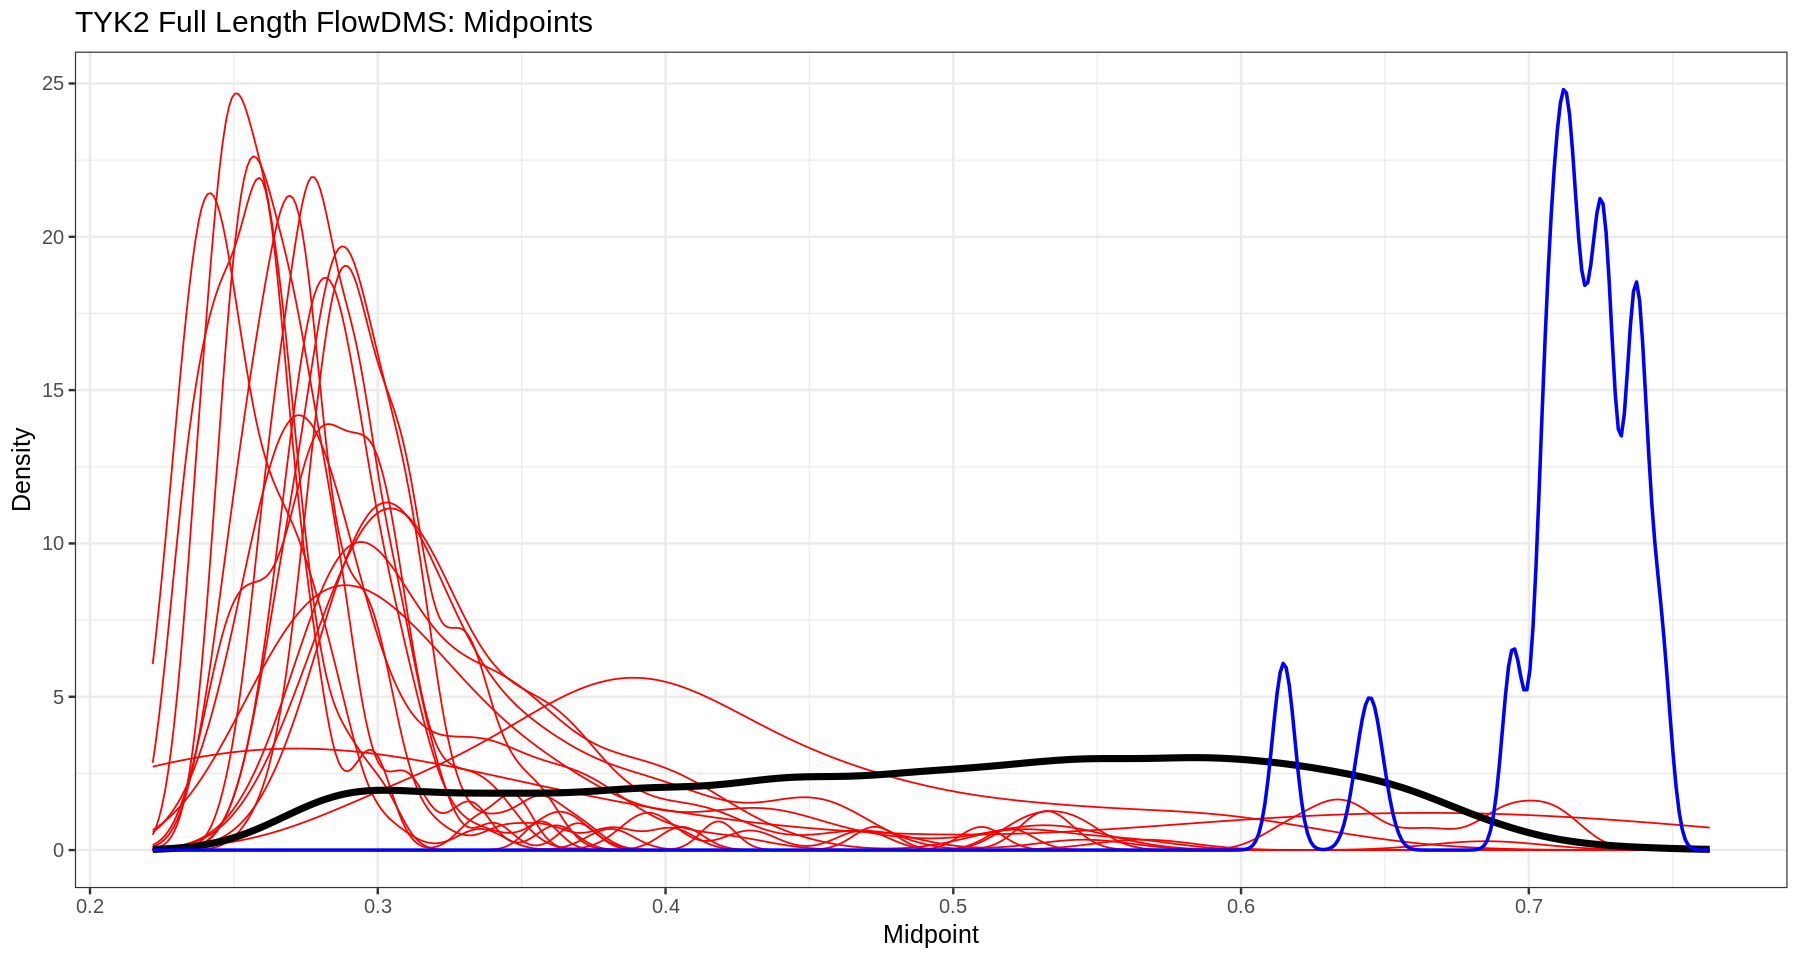

In [78]:
options(repr.plot.width = 15, repr.plot.height = 8)
midpoints %>%
    mutate(group = case_when(mut_aa %in% c("*", "X") ~ chunk,
                             mut_aa == "WT" ~ "WT",
                             TRUE ~ "Non-Stop"),
           colors = case_when(group == "Non-Stop" ~ "black",
                              group == "WT" ~ "blue",
                              TRUE ~ "red")) %>% 
    ggplot() +
        geom_density(aes(x = score_mean,
                         group = group,
                         color = colors,
                         size = colors)) +
        theme_bw(base_size = 15) +
        scale_color_identity() +
        scale_size_manual(values = c("blue" = 1, "black" = 2, "red" = 0.5)) +
        theme(legend.pos = "none") +
        xlab("Midpoint") + ylab("Density") +
        ggtitle("TYK2 Full Length FlowDMS: Midpoints")

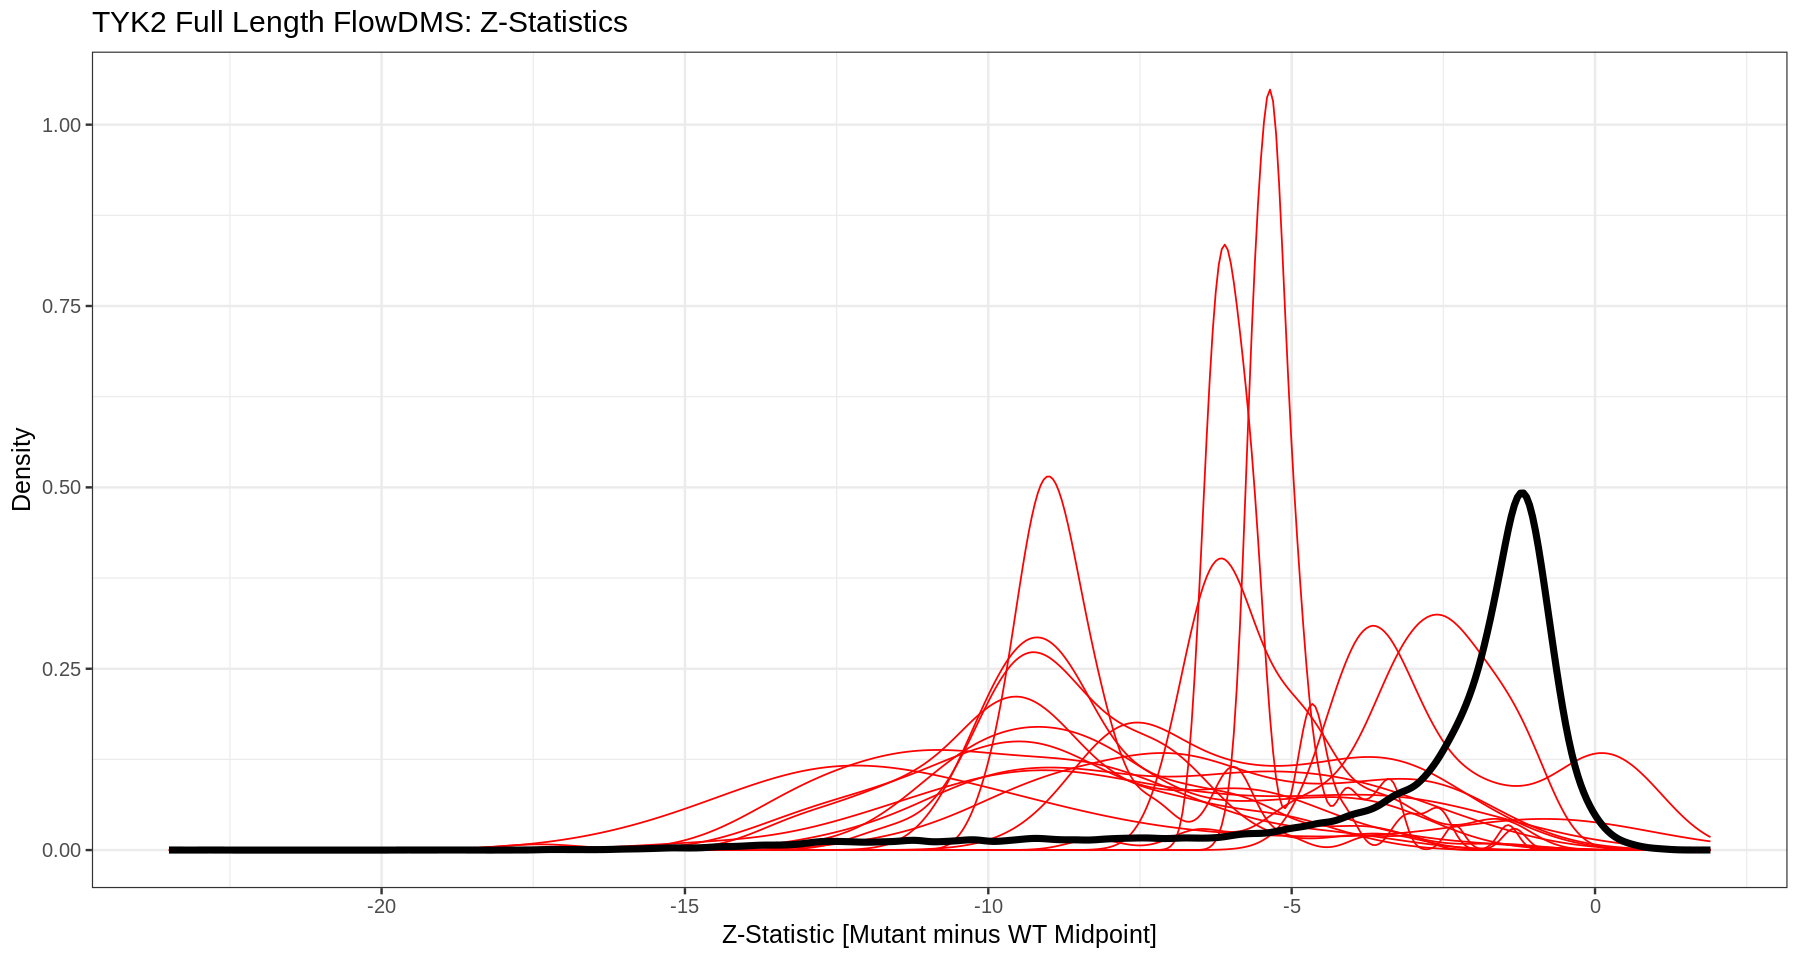

In [79]:
options(repr.plot.width = 15, repr.plot.height = 8)
midpoints_test %>%
    mutate(group = case_when(mut_aa %in% c("*", "X") ~ chunk,
                             mut_aa == "WT" ~ "WT",
                             TRUE ~ "Non-Stop"),
           colors = case_when(group == "Non-Stop" ~ "black",
                              group == "WT" ~ "blue",
                              TRUE ~ "red")) %>% 
    ggplot() +
        geom_density(aes(x = statistic,
                         group = group,
                         color = colors,
                         size = colors)) +
        theme_bw(base_size = 15) +
        scale_color_identity() +
        scale_size_manual(values = c("blue" = 1, "black" = 2, "red" = 0.5)) +
        theme(legend.pos = "none") +
        xlab("Z-Statistic [Mutant minus WT Midpoint]") + ylab("Density") +
        ggtitle("TYK2 Full Length FlowDMS: Z-Statistics")

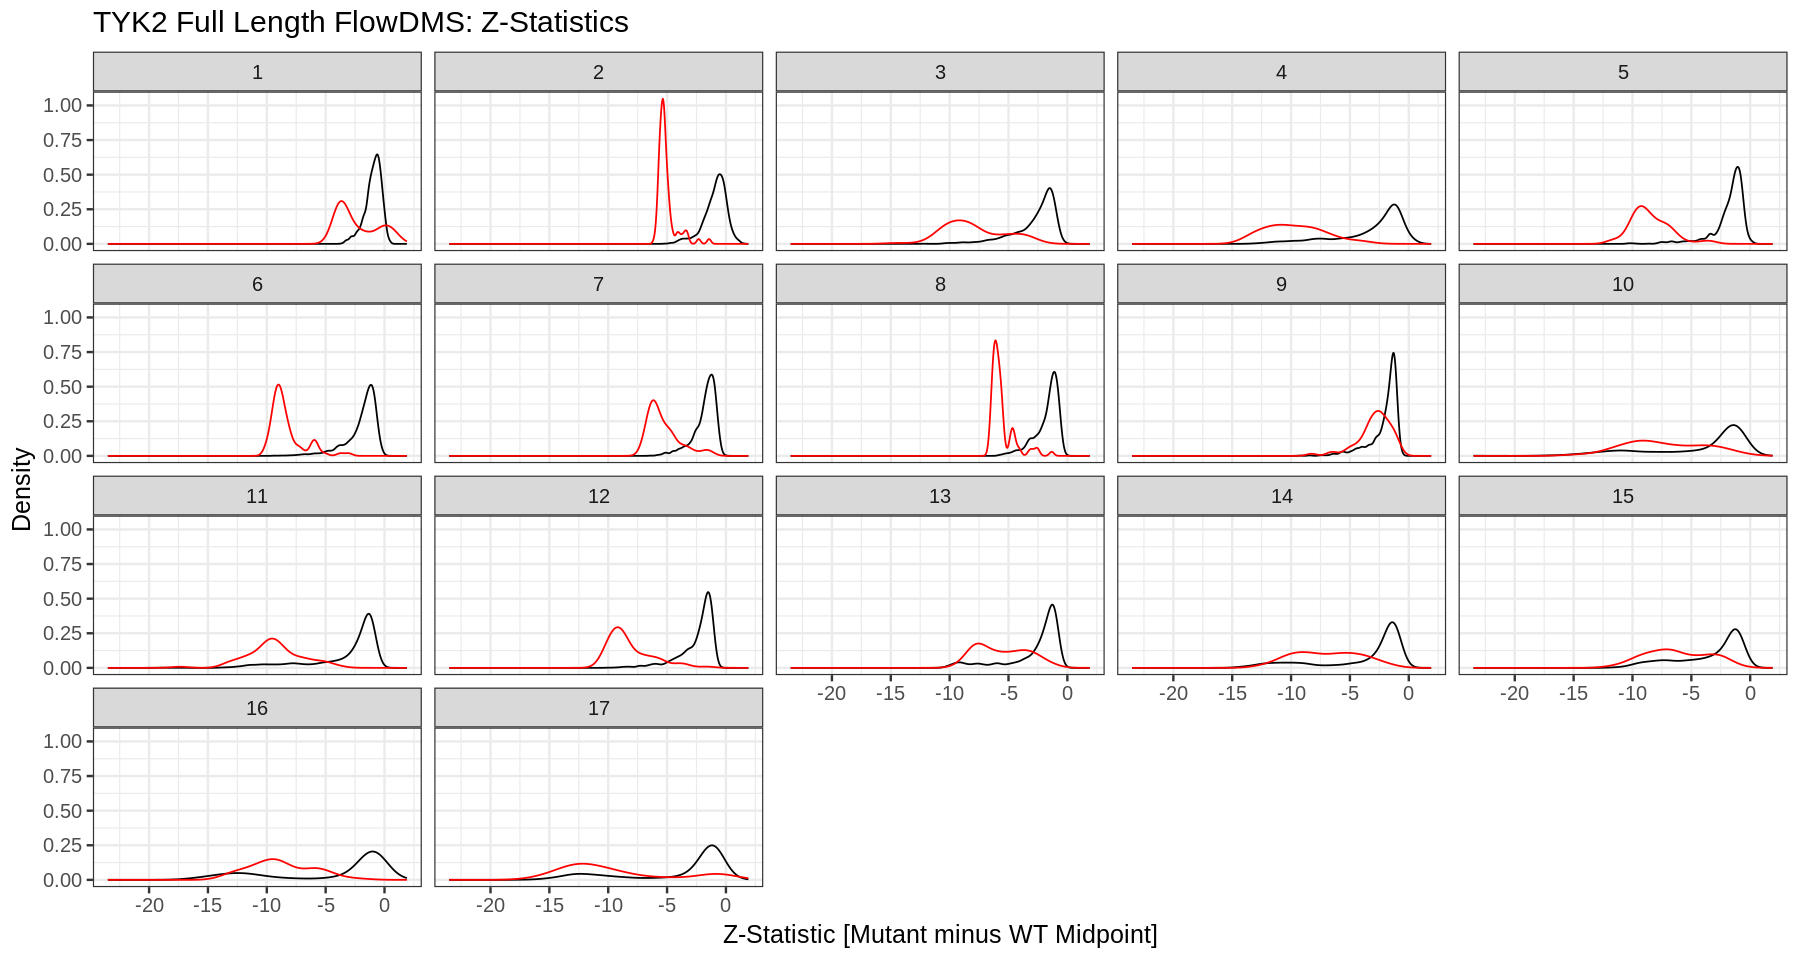

In [80]:
options(repr.plot.width = 15, repr.plot.height = 8)
midpoints_test %>%
    mutate(group = if_else(mut_aa %in% c("X","*"), "red", "black"),
           chunk = if_else(chunk == "12rc", "12", chunk)) %>%
    ggplot() +
        geom_density(aes(x = statistic,
                         group = group,
                         color = group)) +
        theme_bw(base_size = 15) +
        scale_color_identity() +
        theme(legend.pos = "none") +
        xlab("Z-Statistic [Mutant minus WT Midpoint]") + ylab("Density") +
        ggtitle("TYK2 Full Length FlowDMS: Z-Statistics") +
        facet_wrap(~as.numeric(chunk))

### Visualizations <a name="part4"></a>

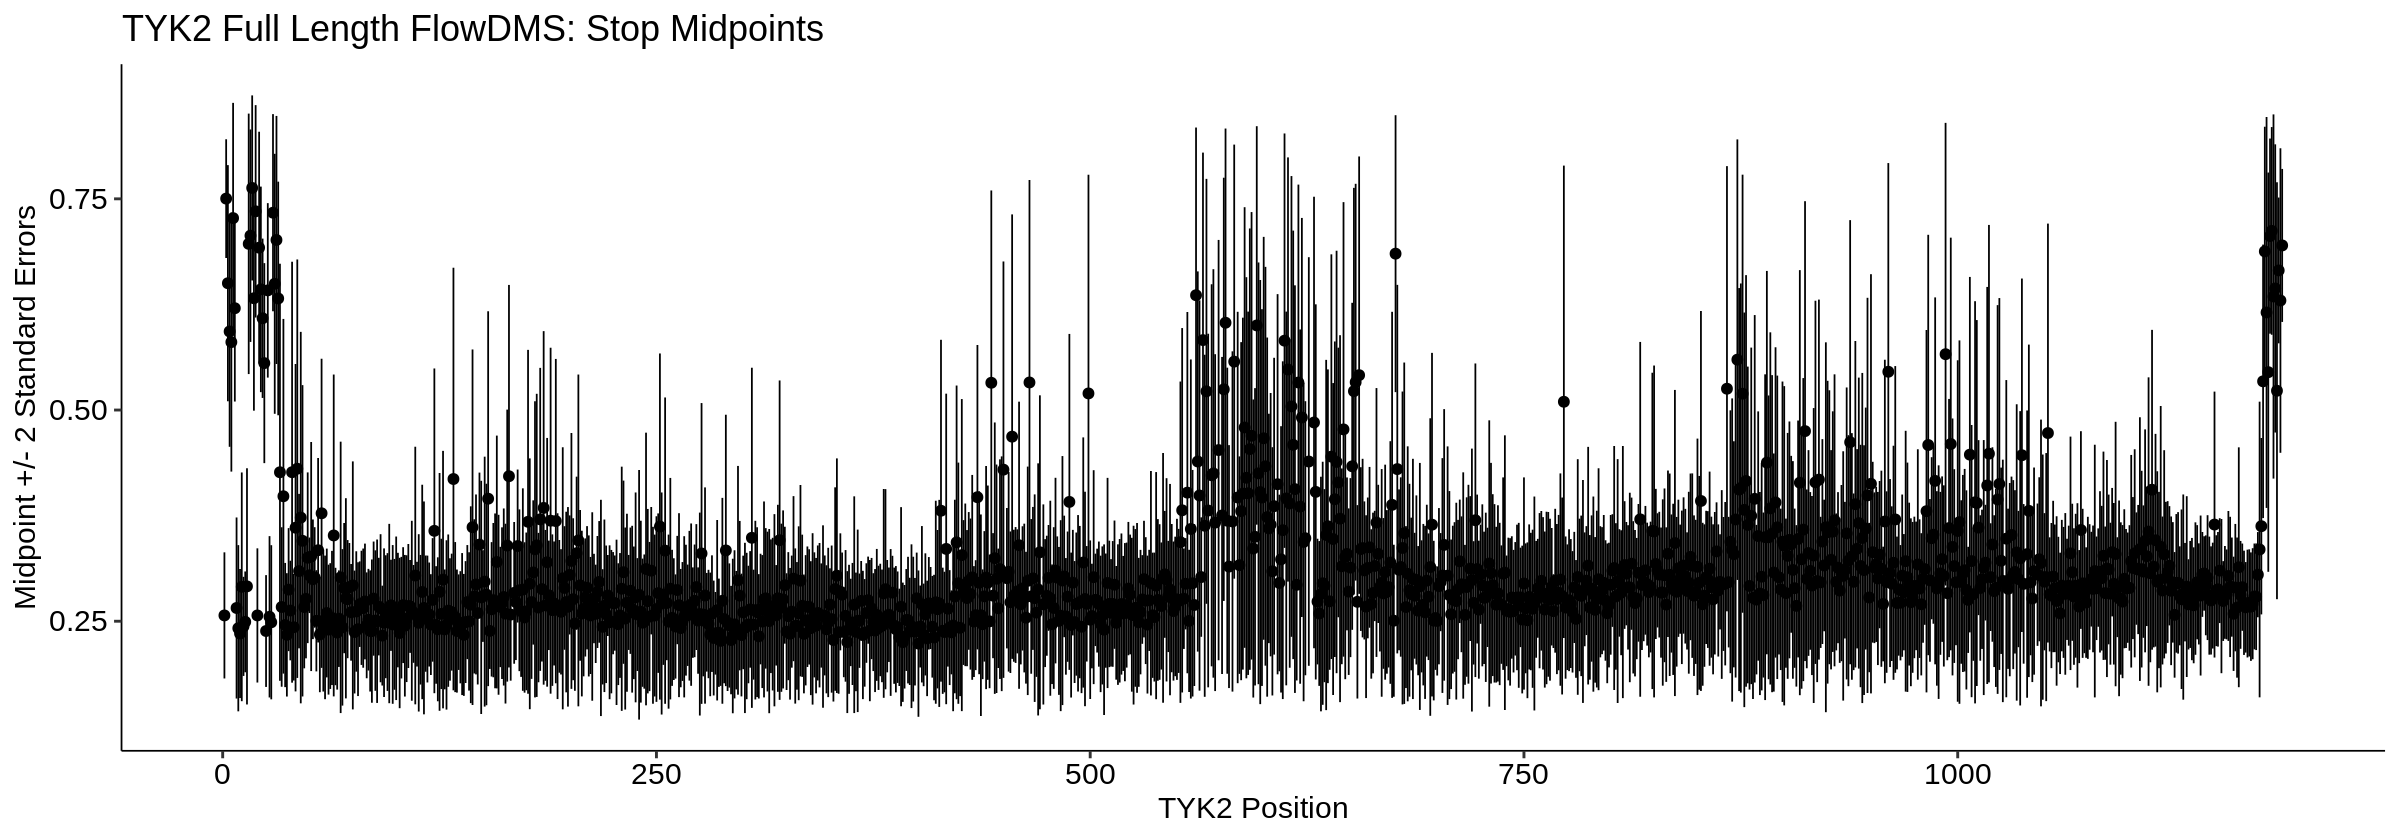

In [81]:
options(repr.plot.width = 20, repr.plot.height = 7)
midpoints %>%
    filter(mut_aa %in% c("X","*")) %>%
    ggplot() +
        geom_pointrange(aes(x = pos, y = score_mean,
                            ymin = score_mean - score_se*2,
                            ymax = score_mean + score_se*2), size = 0.5) +
        theme_pubr(base_size = 18) +
        ggtitle("TYK2 Full Length FlowDMS: Stop Midpoints") +
        xlab("TYK2 Position") + ylab("Midpoint +/- 2 Standard Errors")

In [84]:
heat_midpoint <- midpoints_test %>%
    mutate(mut_aa = if_else(mut_aa %in% c("*", "X"), "Stop", mut_aa)) %>%
    rename("midpoint shift" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(mut_aa), fill = `midpoint shift`)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish, limits = c(-15, 5)) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            ggtitle("Unnormalized")

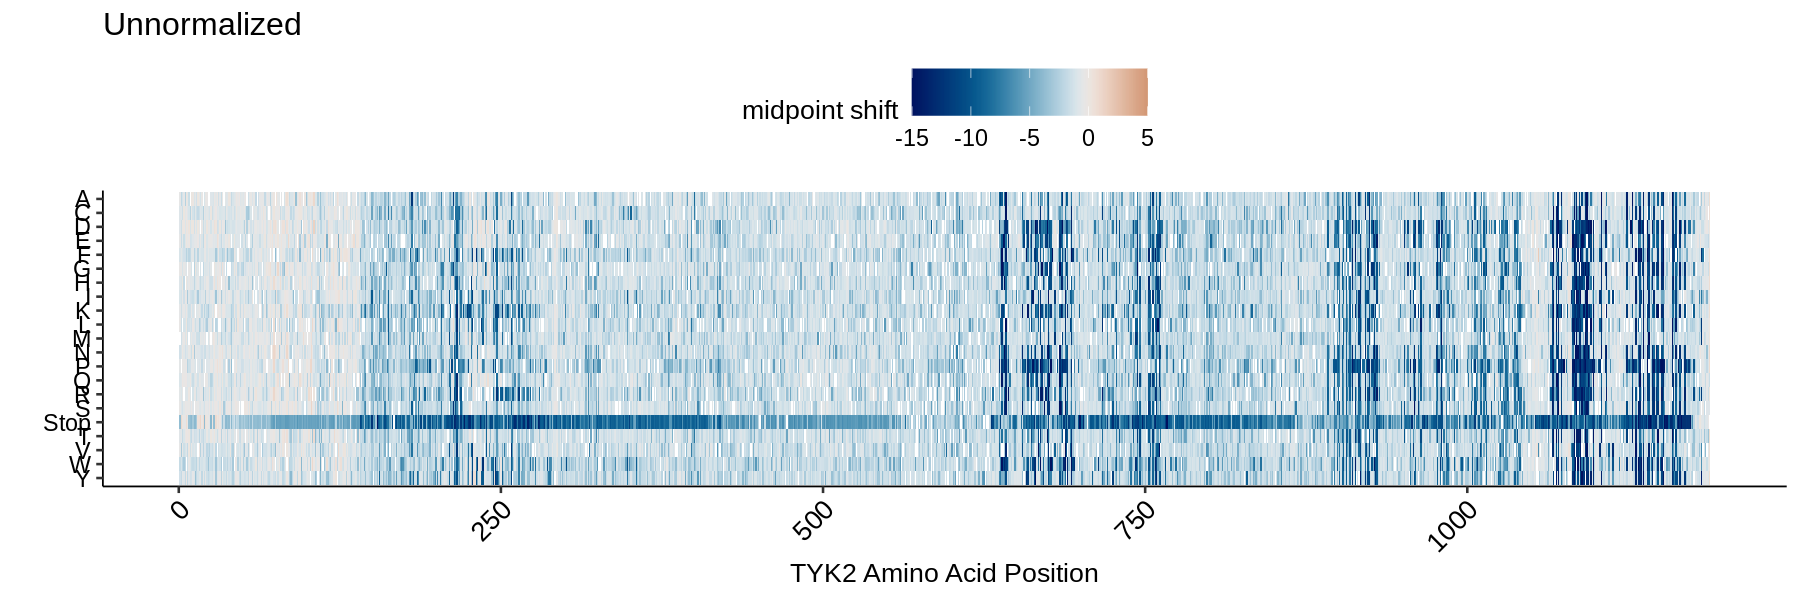

In [85]:
options(repr.plot.width = 15, repr.plot.height = 5)
heat_midpoint